In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import timedelta
from dateutil.parser import parse

data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_84484/278595787.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


### Load mobility data files

### Load/Clean Simple Heatwave Data

In [9]:
#heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave_control/heatwave_control_90_v2.csv')
heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/brazil/THI_heatwave_control_90.csv')

In [10]:
len(heatwave_control['location'].unique())

3618

In [11]:
heatwave_control['Heat Wave Duration'].describe()

count    9572.000000
mean        3.637798
std         2.810849
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        15.000000
Name: Heat Wave Duration, dtype: float64

In [12]:
heatwave_control['control_day'] = [parse(x) for x in heatwave_control['control_day']]
heatwave_control['datetime'] = [parse(x) for x in heatwave_control['datetime']]

In [13]:
(heatwave_control['datetime'] - heatwave_control['control_day']).describe()

count                         34821
mean     10 days 14:58:27.883173946
std       9 days 01:11:56.074212686
min              -56 days +00:00:00
25%                 7 days 00:00:00
50%                 7 days 00:00:00
75%                14 days 00:00:00
max                56 days 00:00:00
dtype: object

In [14]:
heatwave_control['diff'] = (heatwave_control['datetime'] - heatwave_control['control_day'])

In [15]:
temp = pd.DataFrame(heatwave_control['diff'].value_counts()).sort_index()

In [16]:
temp.columns = ['Number of Instances']

Text(0, 0.5, 'Heat and Control Difference')

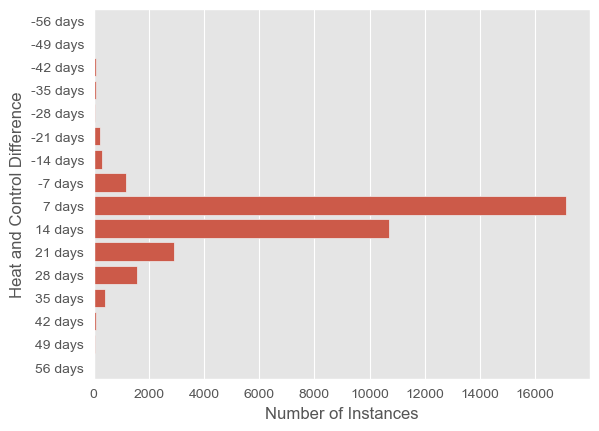

In [17]:
sns.barplot(temp, y=temp.index, x='Number of Instances')
plt.ylabel("Heat and Control Difference")

### Merge Mobility with Heat Data

In [18]:
mobility = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/google_mobility/BR_clean_google.csv')  

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_84484/24297028.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  mobility = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/google_mobility/BR_clean_google.csv')


In [19]:
mobility['location'].value_counts().value_counts()

653    1235
560     115
652      44
651      27
561      17
       ... 
386       1
385       1
379       1
375       1
13        1
Name: location, Length: 346, dtype: int64

In [20]:
mobility['date'].min()

'2021-01-01'

In [21]:
mobility.rename(columns = {
                                'retail_and_recreation_percent_change_from_baseline':'retail_rec', 
                                'grocery_and_pharmacy_percent_change_from_baseline':'grocery_pharm',
                                'parks_percent_change_from_baseline': 'parks', 
                                'transit_stations_percent_change_from_baseline': 'transit', 
                                'workplaces_percent_change_from_baseline':'workplaces',
                                'residential_percent_change_from_baseline': 'residential'}, inplace=True)
                                

In [22]:
mobility.drop_duplicates(['location', 'date'], inplace=True)

In [23]:
mobility['date'] = pd.to_datetime(mobility['date'])

In [25]:
#merge mobility data with heatwave and control day data
mobility_heat = mobility.merge(heatwave_control[['control_day', 'thi', 'location', 'datetime', 'heat_ID']], left_on=['location', 'date'], right_on=['location', 'datetime'])

In [26]:
#get mobility on control day
mobility_heat = mobility_heat.merge(mobility[['location', 'date', 'retail_rec', 'grocery_pharm', 'parks', 'transit', 'workplaces', 'residential']], left_on=['location', 'control_day'], right_on=['location', 'date'], suffixes=['_heat', '_control'])

In [27]:
#calculate differences between heat and control 
mobility_heat['retail_rec_difference'] = mobility_heat['retail_rec_heat'] - mobility_heat['retail_rec_control']
mobility_heat['grocery_pharm_difference'] = mobility_heat['grocery_pharm_heat'] - mobility_heat['grocery_pharm_control']
mobility_heat['parks_difference'] = mobility_heat['parks_heat'] - mobility_heat['parks_control']
mobility_heat['transit_difference'] = mobility_heat['transit_heat'] - mobility_heat['transit_control']
mobility_heat['workplaces_difference'] = mobility_heat['workplaces_heat'] - mobility_heat['workplaces_control']
mobility_heat['residential_difference'] = mobility_heat['residential_heat'] - mobility_heat['residential_control']

In [28]:
mobility_heat['day_of_week'] = [x.day_of_week for x in mobility_heat['date_heat']]
mobility_heat['weekend'] = [1 if x in [5,6] else 0 for x in mobility_heat['day_of_week']]

In [29]:
mobility_heat.reset_index(drop=True,inplace=True)

In [31]:
mobility_heat['datetime'] = pd.to_datetime(mobility_heat['datetime'])

In [32]:
mobility_heat.to_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/brazil/THI_mobility_heat_clean_90.csv')